***

__Import packages__

***

In [1]:
# Required imports
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import openpyxl
import seaborn as sns
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS

import arviz as az
import jax 
from jax import random
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.diagnostics import print_summary

# Set seed for reproducibility
rng_key = random.PRNGKey(1)
np.random.seed(0)

***

__*Preparation*: Import and process farm data__

***

In [2]:
os.chdir("C:/Users/aladesuru/Documents/DataAnalysis/Lab/Niedersachsen")
# Load the farm file into a DataFrame
farmdata = pd.read_excel("data/raw/farmdata/farmNieder_corre.xlsx")
farmdata.info()
farmdata.head()

# count unique years in the dataset
farmdata['year'].nunique()
farmdata['LANDKREIS'].nunique()

#check for missing values
farmdata.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LK         1104 non-null   int64  
 1   LANDKREIS  1104 non-null   object 
 2   klasse     1104 non-null   object 
 3   year       1104 non-null   int64  
 4   anzahl     1097 non-null   float64
 5   LF_ha      1066 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 51.9+ KB


LK            0
LANDKREIS     0
klasse        0
year          0
anzahl        7
LF_ha        38
dtype: int64

In [3]:
#subset the data for where klasse is Ingesamt
farmdata_ge = farmdata[farmdata['klasse'] == 'Insgesamt']
print('shape all',farmdata_ge.shape)


shape all (138, 6)


In [4]:
# Convert column dtypes to appropriate types
farmdata_ge['LK'] = farmdata_ge['LK'].astype(object)

C:\Users\aladesuru\AppData\Local\Temp\ipykernel_18972\3983343443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  farmdata_ge['LK'] = farmdata_ge['LK'].astype(object)


In [5]:
# create a new column 'LF_mean' which is 'LF_ha' divided by 'anzahl'
farmdata_ge['LF_mean'] = farmdata_ge['LF_ha'] / farmdata_ge['anzahl']
farmdata_ge.head()

C:\Users\aladesuru\AppData\Local\Temp\ipykernel_18972\3219583224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  farmdata_ge['LF_mean'] = farmdata_ge['LF_ha'] / farmdata_ge['anzahl']


,LK,LANDKREIS,klasse,year,anzahl,LF_ha,LF_mean
0,0,Niedersachsen,Insgesamt,2010,41271.0,2577017.0,62.441351
8,101,Stadt Braunschweig (kreisfrei),Insgesamt,2010,77.0,6661.0,86.506494
16,102,Stadt Salzgitter (kreisfrei),Insgesamt,2010,104.0,10580.0,101.730769
24,103,Stadt Wolfsburg (kreisfrei),Insgesamt,2010,94.0,8396.0,89.319149
32,151,Gifhorn,Insgesamt,2010,896.0,75710.0,84.497768


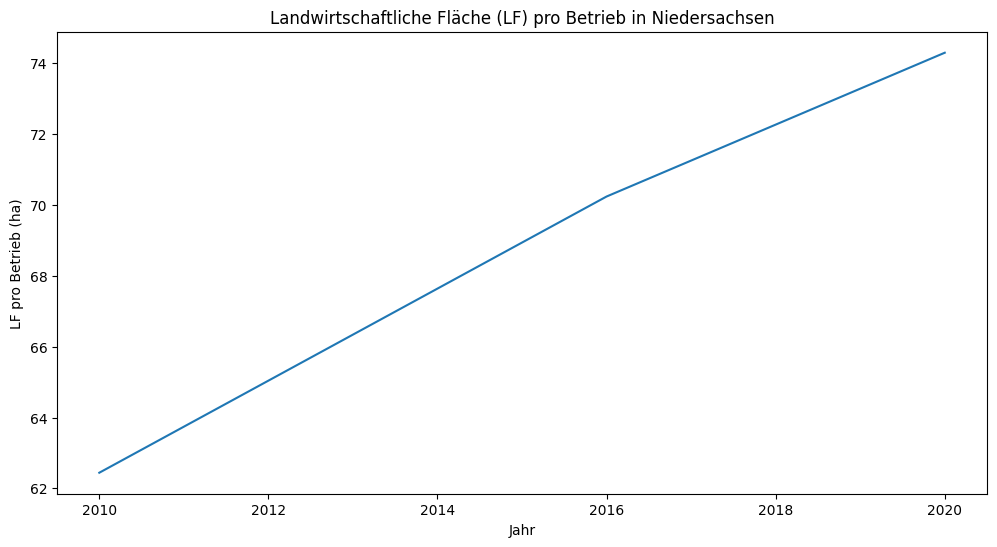

In [6]:
#subset the data for total niedersachsen
farmdata_nieder = farmdata_ge[farmdata_ge['LK'] == 0]
farmdata_nieder

# make a line plot of LF_mean over the years
plt.figure(figsize=(12, 6))
sns.lineplot(data=farmdata_nieder, x='year', y='LF_mean')
plt.title('Landwirtschaftliche Fläche (LF) pro Betrieb in Niedersachsen')
plt.xlabel('Jahr')
plt.ylabel('LF pro Betrieb (ha)')
plt.show()

In [7]:
# drop rows where LK = 0 i.e. Niedersachsen as a whole
farmdata_gecop = farmdata_ge.copy()
farmdata_ge = farmdata_gecop[farmdata_gecop['LK'] != 0]
print('shape without whole niedersachsen rows',farmdata_ge.shape)
farmdata_ge.info()
farmdata_ge['LANDKREIS'].nunique()

shape without whole niedersachsen rows (135, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 135 entries, 8 to 1096
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LK         135 non-null    object 
 1   LANDKREIS  135 non-null    object 
 2   klasse     135 non-null    object 
 3   year       135 non-null    int64  
 4   anzahl     135 non-null    float64
 5   LF_ha      135 non-null    float64
 6   LF_mean    135 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 8.4+ KB


45

In [8]:
# Create a copy of the original dictionary to avoid altering the original data
farmdata_ge_ext = farmdata_ge.copy()

# Ensure the data is sorted by 'LANDKREIS'' and 'year'
farmdata_ge_ext.sort_values(by=['LANDKREIS', 'year'], inplace=True)
numeric_columns = farmdata_ge_ext.select_dtypes(include='number').columns

# Create a dictionary to store the new columns
new_columns = {}

# Calculate yearly difference for numeric columns and store in the dictionary
for col in numeric_columns:
    new_columns[f'{col}_yearly_diff'] = farmdata_ge_ext.groupby('LANDKREIS')[col].diff().fillna(0)
# Calculate yearly relative difference for numeric columns and store in the dictionary
    new_columns[f'{col}_yearly_percdiff'] = (farmdata_ge_ext.groupby('LANDKREIS')[col].diff() / farmdata_ge_ext.groupby('LANDKREIS')[col].shift(1)).fillna(0) * 100

# Concatenate the new columns to the original DataFrame all at once
new_columns_df = pd.DataFrame(new_columns)
farmdata_ge_ydiff = pd.concat([farmdata_ge_ext, new_columns_df], axis=1)
farmdata_ge_ydiff.head()

,LK,LANDKREIS,klasse,year,anzahl,LF_ha,LF_mean,year_yearly_diff,year_yearly_percdiff,anzahl_yearly_diff,anzahl_yearly_percdiff,LF_ha_yearly_diff,LF_ha_yearly_percdiff,LF_mean_yearly_diff,LF_mean_yearly_percdiff
272,451,Ammerland,Insgesamt,2010,1008.0,43611.0,43.264881,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
640,451,Ammerland,Insgesamt,2016,841.0,42654.0,50.718193,6.0,0.298507,-167.0,-16.567460,-957.0,-2.194400,7.453312,17.227163
1008,451,Ammerland,Insgesamt,2020,827.0,42873.0,51.841596,4.0,0.198413,-14.0,-1.664685,219.0,0.513434,1.123404,2.214991
280,452,Aurich,Insgesamt,2010,1431.0,80236.0,56.069881,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
648,452,Aurich,Insgesamt,2016,1315.0,82643.0,62.846388,6.0,0.298507,-116.0,-8.106219,2407.0,2.999900,6.776507,12.085823


In [9]:
fdg_ext = farmdata_ge_ydiff.copy()

fdg_ext['log_AFaS'] = np.log(fdg_ext['LF_mean'])

# sort by LANDKREIS and year
fdg_ext = fdg_ext.sort_values(by=['LANDKREIS', 'year'])

# compute yearly differences for the log_LF_mean column
fdg_ext['d_log_AFaS'] = fdg_ext.groupby('LANDKREIS')['log_AFaS'].diff().fillna(0)

# check the first 10 rows of the dataset
fdg_ext.head(10)

,LK,LANDKREIS,klasse,year,anzahl,LF_ha,LF_mean,year_yearly_diff,year_yearly_percdiff,anzahl_yearly_diff,anzahl_yearly_percdiff,LF_ha_yearly_diff,LF_ha_yearly_percdiff,LF_mean_yearly_diff,LF_mean_yearly_percdiff,log_AFaS,d_log_AFaS
272,451,Ammerland,Insgesamt,2010,1008.0,43611.0,43.264881,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.767341,0.000000
640,451,Ammerland,Insgesamt,2016,841.0,42654.0,50.718193,6.0,0.298507,-167.0,-16.567460,-957.0,-2.194400,7.453312,17.227163,3.926285,0.158943
1008,451,Ammerland,Insgesamt,2020,827.0,42873.0,51.841596,4.0,0.198413,-14.0,-1.664685,219.0,0.513434,1.123404,2.214991,3.948193,0.021908
280,452,Aurich,Insgesamt,2010,1431.0,80236.0,56.069881,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4.026599,0.000000
648,452,Aurich,Insgesamt,2016,1315.0,82643.0,62.846388,6.0,0.298507,-116.0,-8.106219,2407.0,2.999900,6.776507,12.085823,4.140693,0.114095
1016,452,Aurich,Insgesamt,2020,1219.0,82252.0,67.474979,4.0,0.198413,-96.0,-7.300380,-391.0,-0.473119,4.628592,7.364929,4.211757,0.071063
144,351,Celle,Insgesamt,2010,663.0,51166.0,77.173454,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,4.346056,0.000000
512,351,Celle,Insgesamt,2016,632.0,52227.0,82.637658,6.0,0.298507,-31.0,-4.675716,1061.0,2.073643,5.464204,7.080419,4.414465,0.068410
880,351,Celle,Insgesamt,2020,595.0,51610.0,86.739496,4.0,0.198413,-37.0,-5.854430,-617.0,-1.181381,4.101838,4.963642,4.462909,0.048444
288,453,Cloppenburg,Insgesamt,2010,2010.0,93577.0,46.555721,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.840650,0.000000


In [10]:
# drop columns LK, klasse, year_yearly_diff, year_yearly_percdiff  
fdg_ext = fdg_ext.drop(columns=['LK', 'klasse', 'year_yearly_diff', 'year_yearly_percdiff'])
# sort by year
fdg_ext = fdg_ext.sort_values(by='year').reset_index(drop=True)
fdg_ext.head()

,LANDKREIS,year,anzahl,LF_ha,LF_mean,anzahl_yearly_diff,anzahl_yearly_percdiff,LF_ha_yearly_diff,LF_ha_yearly_percdiff,LF_mean_yearly_diff,LF_mean_yearly_percdiff,log_AFaS,d_log_AFaS
0,Ammerland,2010,1008.0,43611.0,43.264881,0.0,0.0,0.0,0.0,0.0,0.0,3.767341,0.0
1,Aurich,2010,1431.0,80236.0,56.069881,0.0,0.0,0.0,0.0,0.0,0.0,4.026599,0.0
2,Celle,2010,663.0,51166.0,77.173454,0.0,0.0,0.0,0.0,0.0,0.0,4.346056,0.0
3,Cloppenburg,2010,2010.0,93577.0,46.555721,0.0,0.0,0.0,0.0,0.0,0.0,3.840650,0.0
4,Cuxhaven,2010,2070.0,134870.0,65.154589,0.0,0.0,0.0,0.0,0.0,0.0,4.176763,0.0


In [11]:
'''Since field data is from 2012 to 2023, for missing yearly data between 2010 and 2023,
let 2010 data be used for 2011 and 2012, 2016 data for 2013 to 2015, and 2020 data for 2017 to 2023'''
# Create a list to store all DataFrames
all_dfs = [fdg_ext]

# Define the years to copy data for
years_to_copy = {2010: range(2011, 2013), 2016: range(2013, 2016), 2020: list(range(2017, 2020)) + list(range(2021, 2024))}

# Loop through the years and create copies
for base_year, copy_years in years_to_copy.items():
    base_data = fdg_ext[fdg_ext['year'] == base_year].copy()
    for year in copy_years:
        df_copy = base_data.copy()
        df_copy['year'] = year
        all_dfs.append(df_copy)

# Concatenate all DataFrames
fdg_ext_all = pd.concat(all_dfs, ignore_index=True)

# Sort the DataFrame by year
fdg_ext_all = fdg_ext_all.sort_values(by='year').reset_index(drop=True)

# print unique years in the dataset
print(fdg_ext_all['year'].unique())

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [12]:
# drop rows for years 2010 and 2011 in df_farm since we now have 2012 which is a coherent baseyear with field data
fdg_ext_all = fdg_ext_all[fdg_ext_all["year"] > 2011]

# print unique years in the dataset
print(fdg_ext_all['year'].unique())

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [13]:
# drop LANDKREIS "Stadt Oldenburg (Oldb) (kreisfrei)" because this is missing in field data
fdg_ext_all = fdg_ext_all[fdg_ext_all['LANDKREIS'] != 'Stadt Oldenburg (Oldb) (kreisfrei)']
fdg_ext_all['LANDKREIS'].nunique()

44

***

__*Preparation*: Import field data and merge to farm data__

***

In [14]:
from src.analysis.desc import gridgdf_desc as gd

# %% load data
_, gridgdf = gd.silence_prints(gd.create_gridgdf)
# I always want to load gridgdf and process clean gridgdf separately so I can have uncleeaned data for comparison or sensitivity analysis
gridgdf_cl, _ = gd.clean_gridgdf(gridgdf)

2025-02-26 14:45:19,197 - INFO - Unique CELLCODES with fields < 300: 62
2025-02-26 14:45:19,222 - INFO - Final unique CELLCODES in outliers: 57


In [15]:
gridgdf_cl.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   CELLCODE                     6156 non-null   object  
 1   year                         6156 non-null   int32   
 2   LANDKREIS                    6156 non-null   object  
 3   fields                       6156 non-null   int64   
 4   group_count                  6156 non-null   int64   
 5   fsm2_sum                     6156 non-null   float64 
 6   fsha_sum                     6156 non-null   float64 
 7   peri_sum                     6156 non-null   float64 
 8   par_sum                      6156 non-null   float64 
 9   mfs_ha                       6156 non-null   float64 
 10  mperi                        6156 non-null   float64 
 11  mpar                         6156 non-null   float64 
 12  medfs_ha                     6156 non-null   float64 


In [16]:
gridgdf_clc = gridgdf_cl.copy()  # Ensure it's a valid copy

# drop geometry column
gridgdf_clc = gridgdf_clc.drop(columns='geometry')


In [17]:
# yearly differences for log_medfs_ha
#create log columsn for medfs_ha
gridgdf_clc['log_AFiS'] = np.log(gridgdf_clc['medfs_ha'])

gridgdf_clc.sort_values(by=['CELLCODE', 'year'], inplace=True)

gridgdf_clc['d_log_AFiS'] = gridgdf_clc.groupby('CELLCODE')['log_AFiS'].diff().fillna(0)

# check the first 10 rows of the dataset
gridgdf_clc[['CELLCODE', 'year', 'medfs_ha', 'medfs_ha_yearly_percdiff', 'log_AFiS', 'd_log_AFiS']].head(10)

,CELLCODE,year,medfs_ha,medfs_ha_yearly_percdiff,log_AFiS,d_log_AFiS
0,10kmE410N326,2012,2.385932,0.000000,0.869590,0.000000
1,10kmE410N326,2013,2.350738,-1.475078,0.854729,-0.014861
2,10kmE410N326,2014,2.223233,-5.424039,0.798962,-0.055767
3,10kmE410N326,2015,2.217493,-0.258193,0.796377,-0.002585
4,10kmE410N326,2016,2.227422,0.447779,0.800845,0.004468
5,10kmE410N326,2017,2.230990,0.160203,0.802446,0.001601
6,10kmE410N326,2018,2.275191,1.981190,0.822064,0.019618
7,10kmE410N326,2019,2.320561,1.994146,0.841809,0.019745
8,10kmE410N326,2020,2.300931,-0.845908,0.833314,-0.008495
9,10kmE410N326,2021,2.316277,0.666930,0.839961,0.006647


In [18]:
# drop columns and Landkreise not in farm data from gridgdf_cl
# potentials include 'geometry','fsha_sum', 'fields', 'fields_yearly_percdiff', 'fields_yearly_diff','mfs_ha',  
#'medfs_ha_yearly_diff', 'fsha_sum_yearly_diff', 'fsha_sum_yearly_percdiff', 'mfs_ha_yearly_diff', 'mfs_ha_yearly_percdiff',
# Specify the columns to keep
columns_to_keep = [
    'LANDKREIS', 'CELLCODE', 'year', 'medfs_ha', 'medfs_ha_yearly_percdiff', 'log_AFiS', 'd_log_AFiS'
]

# Drop all other columns
field_grids = gridgdf_clc[columns_to_keep]

field_grids = field_grids[~field_grids["LANDKREIS"].isin(["Küstenmeer Region Lüneburg", "Küstenmeer Region Weser-Ems"])]
print('total regions in field data', field_grids['LANDKREIS'].nunique())

#rest index
field_grids = field_grids.reset_index(drop=True)
field_grids.info()

total regions in field data 44
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036 entries, 0 to 6035
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LANDKREIS                 6036 non-null   object 
 1   CELLCODE                  6036 non-null   object 
 2   year                      6036 non-null   int32  
 3   medfs_ha                  6036 non-null   float64
 4   medfs_ha_yearly_percdiff  6036 non-null   float64
 5   log_AFiS                  6036 non-null   float64
 6   d_log_AFiS                6036 non-null   float64
dtypes: float64(4), int32(1), object(2)
memory usage: 306.6+ KB


In [19]:
# %%
# Standardize 'LANDKREIS' column in both DataFrames
df_farm = fdg_ext_all.copy()
df_field = field_grids.copy()

df_field["LANDKREIS"] = df_field["LANDKREIS"].str.strip()
df_farm["LANDKREIS"] = df_farm["LANDKREIS"].str.strip()

# Get unique LANDKREIS values from both DataFrames
farm_landkreise = set(df_farm["LANDKREIS"].unique())
field_landkreise = set(df_field["LANDKREIS"].unique())

# Check if they are the same
if farm_landkreise == field_landkreise:
    print("✅ LANDKREIS values in df_farm and df_field match exactly!")
else:
    print("❌ There are differences in LANDKREIS values between the two DataFrames.")
    
    # Find mismatched values
    only_in_farm = farm_landkreise - field_landkreise
    only_in_field = field_landkreise - farm_landkreise
    
    print(f"⚠️ Present in df_farm but missing in df_field: {only_in_farm}")
    print(f"⚠️ Present in df_field but missing in df_farm: {only_in_field}")


❌ There are differences in LANDKREIS values between the two DataFrames.
⚠️ Present in df_farm but missing in df_field: {'Hannover,Region'}
⚠️ Present in df_field but missing in df_farm: {'Region Hannover'}


In [20]:
# there is inconsistency in naming Hannover region. Therefore:
df_farm["LANDKREIS"] = df_farm["LANDKREIS"].replace("Hannover,Region", "Region Hannover")

# Get unique LANDKREIS values from both DataFrames
farm_landkreise = set(df_farm["LANDKREIS"].unique())
field_landkreise = set(df_field["LANDKREIS"].unique())

# Check if they are the same
if farm_landkreise == field_landkreise:
    print("✅ LANDKREIS values in df_farm and df_field match exactly!")
else:
    print("❌ There are differences in LANDKREIS values between the two DataFrames.")
    
    # Find mismatched values
    only_in_farm = farm_landkreise - field_landkreise
    only_in_field = field_landkreise - farm_landkreise
    
    print(f"⚠️ Present in df_farm but missing in df_field: {only_in_farm}")
    print(f"⚠️ Present in df_field but missing in df_farm: {only_in_field}")


✅ LANDKREIS values in df_farm and df_field match exactly!


In [21]:
df_farm.info()
df_field.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 90 to 629
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LANDKREIS                528 non-null    object 
 1   year                     528 non-null    int64  
 2   anzahl                   528 non-null    float64
 3   LF_ha                    528 non-null    float64
 4   LF_mean                  528 non-null    float64
 5   anzahl_yearly_diff       528 non-null    float64
 6   anzahl_yearly_percdiff   528 non-null    float64
 7   LF_ha_yearly_diff        528 non-null    float64
 8   LF_ha_yearly_percdiff    528 non-null    float64
 9   LF_mean_yearly_diff      528 non-null    float64
 10  LF_mean_yearly_percdiff  528 non-null    float64
 11  log_AFaS                 528 non-null    float64
 12  d_log_AFaS               528 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 57.8+ KB
<class 'pandas.core.frame

In [22]:
# merge df_farm and df_field using the LANDKREIS and year columns, inner join
farm_field = df_farm.merge(df_field, on=["LANDKREIS", "year"])

farm_field.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036 entries, 0 to 6035
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LANDKREIS                 6036 non-null   object 
 1   year                      6036 non-null   int64  
 2   anzahl                    6036 non-null   float64
 3   LF_ha                     6036 non-null   float64
 4   LF_mean                   6036 non-null   float64
 5   anzahl_yearly_diff        6036 non-null   float64
 6   anzahl_yearly_percdiff    6036 non-null   float64
 7   LF_ha_yearly_diff         6036 non-null   float64
 8   LF_ha_yearly_percdiff     6036 non-null   float64
 9   LF_mean_yearly_diff       6036 non-null   float64
 10  LF_mean_yearly_percdiff   6036 non-null   float64
 11  log_AFaS                  6036 non-null   float64
 12  d_log_AFaS                6036 non-null   float64
 13  CELLCODE                  6036 non-null   object 
 14  medfs_ha

In [23]:
farm_field['LANDKREIS'].nunique()

44

In [24]:
# Get unique LANDKREIS values from both DataFrames
farm_landkreise = set(df_farm["LANDKREIS"].unique())
field_landkreise = set(df_field["LANDKREIS"].unique())
farm_field_landkreise = set(farm_field["LANDKREIS"].unique())

# Check if they are the same
if farm_landkreise == field_landkreise == farm_field_landkreise:
    print("✅ LANDKREIS values in df_farm, df_field and farm_field match exactly!")
else:
    print("❌ There are differences in LANDKREIS values between the two DataFrames.")
    
    # Find mismatched values
    only_in_farm = farm_landkreise - field_landkreise - farm_field_landkreise
    only_in_field = field_landkreise - farm_landkreise - farm_field_landkreise
    only_in_farm_field = farm_field_landkreise - field_landkreise - farm_landkreise
    
    print(f"⚠️ Present in df_farm but missing in df_field and farm_field: {only_in_farm}")
    print(f"⚠️ Present in df_field but missing in df_farm and farm_field: {only_in_field}")
    print(f"⚠️ Present in farm_field but missing in df_farm and df_field: {only_in_farm_field}")
    
    

✅ LANDKREIS values in df_farm, df_field and farm_field match exactly!


In [25]:
farm_field['year'].nunique()

12

In [26]:
# drop 2012 data from farm_field because of 0 values
farm_field1 = farm_field[farm_field["year"] != 2012]
farm_field1['year'].nunique()

11

***
# Testing Relationship

***

## 1. Correlation test and plot

**First, lets see the correlation plot of farm size change and field size change**
It helps to check this with log and non-log data so as to examine the difference before proceeding.

Correlation coefficient between d_log_AFaS and d_log_AFiS: 0.12064524324202489
Correlation coefficient between LF_mean_yearly_percdiff and medfs_ha_yearly_percdiff: 0.11961731461613632
Slope of regression line for log-transformed data: 0.09133849552524548
Slope of regression line for non-log-transformed data: 0.08254565017932808


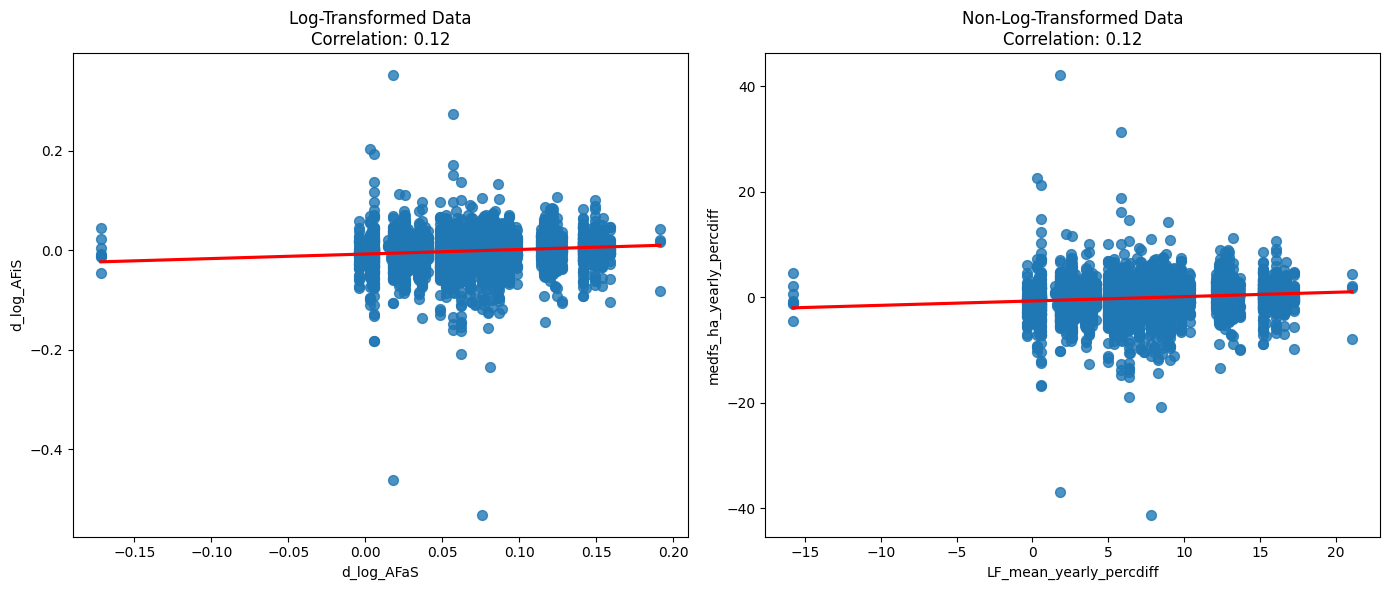

In [27]:
# Calculate the correlation coefficients
#2. for the rate change model variables
corr_log = farm_field1['d_log_AFaS'].corr(farm_field1['d_log_AFiS'])	
corr_non_log = farm_field1['LF_mean_yearly_percdiff'].corr(farm_field1['medfs_ha_yearly_percdiff']) #non-log counterparts

# Print the correlation coefficients
print(f"Correlation coefficient between d_log_AFaS and d_log_AFiS: {corr_log}")
print(f"Correlation coefficient between LF_mean_yearly_percdiff and medfs_ha_yearly_percdiff: {corr_non_log}")

# Fit linear regression models to get the slopes
model_log = smf.ols('d_log_AFiS ~ d_log_AFaS', data=farm_field1).fit()
slope_log = model_log.params['d_log_AFaS']

model_non_log = smf.ols('medfs_ha_yearly_percdiff ~ LF_mean_yearly_percdiff', data=farm_field1).fit()
slope_non_log = model_non_log.params['LF_mean_yearly_percdiff']

# Print the slopes
print(f"Slope of regression line for log-transformed data: {slope_log}")
print(f"Slope of regression line for non-log-transformed data: {slope_non_log}")

# Create side-by-side scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for log-transformed data
sns.regplot(x='d_log_AFaS', y='d_log_AFiS', data=farm_field1, ax=axes[0], ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
axes[0].set_title(f'Log-Transformed Data\nCorrelation: {corr_log:.2f}')
axes[0].set_xlabel('d_log_AFaS')

# Scatter plot for non-log-transformed data
sns.regplot(x='LF_mean_yearly_percdiff', y='medfs_ha_yearly_percdiff', data=farm_field1, ax=axes[1], ci=None, scatter_kws={'s': 50}, line_kws={'color': 'red'})
axes[1].set_title(f'Non-Log-Transformed Data\nCorrelation: {corr_non_log:.2f}')
axes[1].set_xlabel('LF_mean_yearly_percdiff')

plt.tight_layout()
plt.show()


***

## Modelling

***

## Log-Log model of elasticity between field size change and farm size change

We specify a **scientific model** with possible fixed entity effects to include

$ ∆Ln(AFiS_{it}) = \beta_0 + \beta_1 ∆Ln(AFaS_{it}) + \alpha_i + \alpha_t + \varepsilon_{it}$

where:  
- $ ∆Ln(AFiS_{it}) $ = Change in average field size (AFiS)
- $ ∆Ln(AFaS_{it}) $ = Change in average farm size (AFaS) 
- $ \beta_0 $ = Common intercept      
- $ \alpha $ = Entity and Time-fixed characteristics    
- $ \varepsilon_{it} $ = Error term 
- $ i $ = Individual grid cells
- $ t $ = Time


***
__*One*: First differencing without entity__

***
i.e., using the change variables (2013-2012, 2014 - 2013, etc.) without fixed entity effect


$ ∆Ln(AFiS_{it}) = \beta_1∆Ln(AFaS_{it}) + \varepsilon_{it}$


In [28]:
df = farm_field1.copy()

#df = df.set_index(["CELLCODE", "year"])
fd_model1 = smf.ols('d_log_AFiS ~ d_log_AFaS', data=df).fit()
print("=== First Difference (FD) Model Results ===")
print(fd_model1.summary())

=== First Difference (FD) Model Results ===
                            OLS Regression Results                            
Dep. Variable:             d_log_AFiS   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     81.69
Date:                Wed, 26 Feb 2025   Prob (F-statistic):           2.16e-19
Time:                        14:45:26   Log-Likelihood:                 11502.
No. Observations:                5533   AIC:                        -2.300e+04
Df Residuals:                    5531   BIC:                        -2.299e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

***
__First differencing with entity__

***


with time fixed effect

In [32]:
df = farm_field1.copy()

df = df.set_index(["LANDKREIS", "year"])
fd_model2 = PanelOLS.from_formula('d_log_AFiS ~ d_log_AFaS + TimeEffects', data=df).fit()

print("=== First Difference (FD) Model with Time Effects Results ===")
print(fd_model2)

=== First Difference (FD) Model with Time Effects Results ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             d_log_AFiS   R-squared:                        0.0102
Estimator:                   PanelOLS   R-squared (Between):             -1.0597
No. Observations:                5533   R-squared (Within):               0.0031
Date:                Wed, Feb 26 2025   R-squared (Overall):             -0.0568
Time:                        14:46:20   Log-likelihood                 1.182e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      56.877
Entities:                          44   P-value                           0.0000
Avg Obs:                       125.75   Distribution:                  F(1,5521)
Min Obs:                       11.000                                           
Max Obs:                       363.00   F-stati

In [33]:
df = farm_field1.copy()

df = df.set_index(["LANDKREIS", "year"])
fd_model3 = PanelOLS.from_formula('d_log_AFiS ~ d_log_AFaS + EntityEffects', data=df).fit()

print("=== First Difference (FD) Model with Entity Effects Results ===")
print(fd_model3)

=== First Difference (FD) Model with Entity Effects Results ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             d_log_AFiS   R-squared:                        0.0045
Estimator:                   PanelOLS   R-squared (Between):             -0.5201
No. Observations:                5533   R-squared (Within):               0.0045
Date:                Wed, Feb 26 2025   R-squared (Overall):             -0.0196
Time:                        14:46:48   Log-likelihood                  1.16e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      24.744
Entities:                          44   P-value                           0.0000
Avg Obs:                       125.75   Distribution:                  F(1,5488)
Min Obs:                       11.000                                           
Max Obs:                       363.00   F-sta

In [34]:
df = farm_field1.copy()

df = df.set_index(["LANDKREIS", "year"])
fd_model4 = PanelOLS.from_formula('d_log_AFiS ~ d_log_AFaS + TimeEffects + EntityEffects', data=df).fit()

print("=== First Difference (FD) Model with Time & Entity Effects Results ===")
print(fd_model4)

=== First Difference (FD) Model with Time & Entity Effects Results ===
                          PanelOLS Estimation Summary                           
Dep. Variable:             d_log_AFiS   R-squared:                      4.27e-07
Estimator:                   PanelOLS   R-squared (Between):              0.0043
No. Observations:                5533   R-squared (Within):              -0.0002
Date:                Wed, Feb 26 2025   R-squared (Overall):             -0.0002
Time:                        14:48:19   Log-likelihood                 1.194e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0023
Entities:                          44   P-value                           0.9614
Avg Obs:                       125.75   Distribution:                  F(1,5478)
Min Obs:                       11.000                                           
Max Obs:                       363.00 

In [ ]:
# Set MultiIndex (CODE, year) for panel data with farm_field data containing 2012 data
panel_data = farm_field.set_index(['CELLCODE', 'year'])

In [99]:
# --- Fixed Effects (FE) Model with Year Dummies ---
# Create year dummies
year_dummies = pd.get_dummies(panel_data.reset_index()['year'], prefix='year', drop_first=True)
fe_data = panel_data.reset_index().join(year_dummies)

In [101]:
# Prepare variables
X_fe_cols = ['log_AFaS'] + [col for col in fe_data.columns if 'year_' in col]
X_fe = fe_data[X_fe_cols]
X_fe = sm.add_constant(X_fe)
y_fe = fe_data['log_AFiS']


In [103]:
# Fixed effects regression (using entity effects in PanelOLS)
fe_data.set_index(['CELLCODE', 'year'], inplace=True)

try:
    fe_model = PanelOLS.from_formula(
        'log_AFiS ~ log_AFaS + ' + ' + '.join([col for col in X_fe.columns if 'year_' in col]) + ' + EntityEffects',
        data=fe_data
    ).fit()

    print("\n=== Fixed Effects (FE) Model Results ===")
    print(fe_model.summary)

except Exception as e:
    print(f"Error during FE model estimation: {e}")


=== Fixed Effects (FE) Model Results ===
                          PanelOLS Estimation Summary                           
Dep. Variable:               log_AFiS   R-squared:                        0.1183
Estimator:                   PanelOLS   R-squared (Between):             -6.7980
No. Observations:                6036   R-squared (Within):               0.1183
Date:                Sun, Feb 23 2025   R-squared (Overall):             -6.7696
Time:                        11:50:21   Log-likelihood                 1.051e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      61.732
Entities:                         503   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                 F(12,5521)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):      

In [115]:
# --- Summary of Key Differences ---
print("\n--- Key Takeaways ---")
print(f"First difference Elasticity (b1): {fd_model1.params['d_log_AFaS']:.4f}")
print(f"First difference with Time Effect Elasticity (b1): {fd_model2.params['d_log_AFaS']:.4f}")
print(f"Fixed Time and Entity Effect Elasticity (b1): {fe_model2.params['log_AFaS']:.4f}")

# The FD model shows the year-over-year relationship.
# The FE model shows within-individual elasticity relative to 2012 (baseline year).
# Differences in estimates reflect how each model treats time-invariant characteristics and time trends.


--- Key Takeaways ---
First difference Elasticity (b1): 0.0913
First difference with Time Effect Elasticity (b1): 0.0988
Fixed Time and Entity Effect Elasticity (b1): 0.6260
